# KBO 승률 예측

<b>각 시즌의 팀 별 성적(Stat)이 좋으면 승률이 좋다</b>는 가설을 세우고 이를 증명하기 위한 프로젝트 시작

성적과 승률의 상관관계를 검증

어떤 의미를 갖는가? 현재까지의 성적을 가지고 승률, 순위 예측에 활용할 수 있다.

---

## 필요한 라이브러리 가져오기

In [253]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

mpl.rc('font', family='NanumGothic')  # matplotlib에서 한글 폰트로 NanumGothic을 사용
mpl.rcParams['axes.unicode_minus'] = False

## 학습에 사용할 데이터

KBO 리그의 세이버메트릭스를 전문적으로 다루는 야구 통계 사이트인 Statiz와 KBO 기록실에서 크롤링하여 합친 데이터

데이터 설명에 추가 필요

### 데이터 가져오기

In [11]:
data = pd.read_csv('./KBO_1982_2020_Team_Stats_Rank_EN.csv')
data.head()

,No,Name,Year,G_B,PA,AB,R_B,H_B,2B_B,3B_B,...,ERA+,FIP+,WAR_P,WPA_P,Rank,G,W_T,L_T,D,P
0,1,MBC,1982,952,3061,2686,419,757,124,12,...,113.0,112.6,16.09,NaN,3,80,46,34,0,0.575
1,2,삼성,1982,887,3043,2647,429,705,126,18,...,147.1,113.2,21.11,NaN,2,80,54,26,0,0.675
2,3,OB,1982,930,3098,2745,399,778,137,23,...,121.6,108.3,18.28,NaN,1,80,56,24,0,0.700
3,4,해태,1982,873,2990,2665,374,696,110,14,...,101.7,102.8,11.88,NaN,4,80,38,42,0,0.475
4,5,롯데,1982,863,3062,2628,353,674,112,8,...,100.6,105.7,13.66,NaN,5,80,31,49,0,0.388


In [14]:
data['P'].describe()

count    299.000000
mean       0.503321
std        0.086801
min        0.188000
25%        0.448000
50%        0.508000
75%        0.563000
max        0.706000
Name: P, dtype: float64

In [13]:
print(data.shape)

(299, 65)


### 승률 데이터의 분포

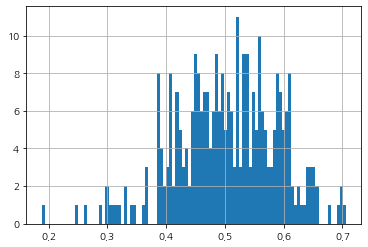

In [21]:
data['P'].hist(bins=100)

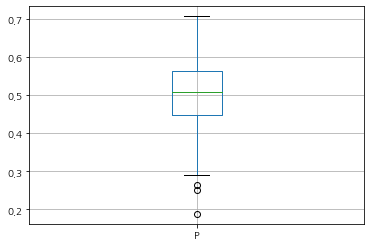

In [22]:
data.boxplot(column=['P'])

Outliers가 3개 표시되는데, 데이터를 살펴봤을 때 승률(P)이 차례로 <b>0.188, 0.25, 0.265</b> 인 데이터였다.

이 데이터들을 포함하고 학습했더니 결과에 좋지 않은 영향을 미치는 것 같아 제거하고 학습하기로 결정했다.

### Outliers 제거

In [255]:
outlier1 = data[data['P'] == 0.188].index
outlier2 = data[data['P'] == 0.25].index
outlier3 = data[data['P'] == 0.265].index
data = data.drop(outlier1)
data = data.drop(outlier2)
data = data.drop(outlier3)

### NaN, 빈 셀 처리

데이터 특성 상 빈 값을 0으로 채우는 것이 학습 결과에 가장 적은 영향을 미칠 것으로 판단했기 때문에 빈 셀은 0으로 처리한다.

In [256]:
data = data.fillna(0)
data.head()

,No,Name,Year,G_B,PA,AB,R_B,H_B,2B_B,3B_B,...,ERA+,FIP+,WAR_P,WPA_P,Rank,G,W_T,L_T,D,P
0,1,MBC,1982,952,3061,2686,419,757,124,12,...,113.0,112.6,16.09,0.0,3,80,46,34,0,0.575
1,2,삼성,1982,887,3043,2647,429,705,126,18,...,147.1,113.2,21.11,0.0,2,80,54,26,0,0.675
2,3,OB,1982,930,3098,2745,399,778,137,23,...,121.6,108.3,18.28,0.0,1,80,56,24,0,0.700
3,4,해태,1982,873,2990,2665,374,696,110,14,...,101.7,102.8,11.88,0.0,4,80,38,42,0,0.475
4,5,롯데,1982,863,3062,2628,353,674,112,8,...,100.6,105.7,13.66,0.0,5,80,31,49,0,0.388


In [311]:
data.to_csv('ttt.csv', encoding='cp949', index=False)

---

## 회귀 분석

먼저 기계학습을 통해 회귀 분석을 진행한다.

야구 데이터의 특성 상 다중공선성이 높게 나타나기 때문에 전처리 과정에서 VIF 계수를 측정해 학습에 사용할 변수를 걸러내고

그럼에도 특성들이 상관관계가 있다면, 규제가 있는 모델을 이용해서 학습한다.

### Feature, Label 분리

In [257]:
X = data[data.columns.difference(['No', 'Name', 'P'])]
y = data['P']

### Feature의 상관관계 분석

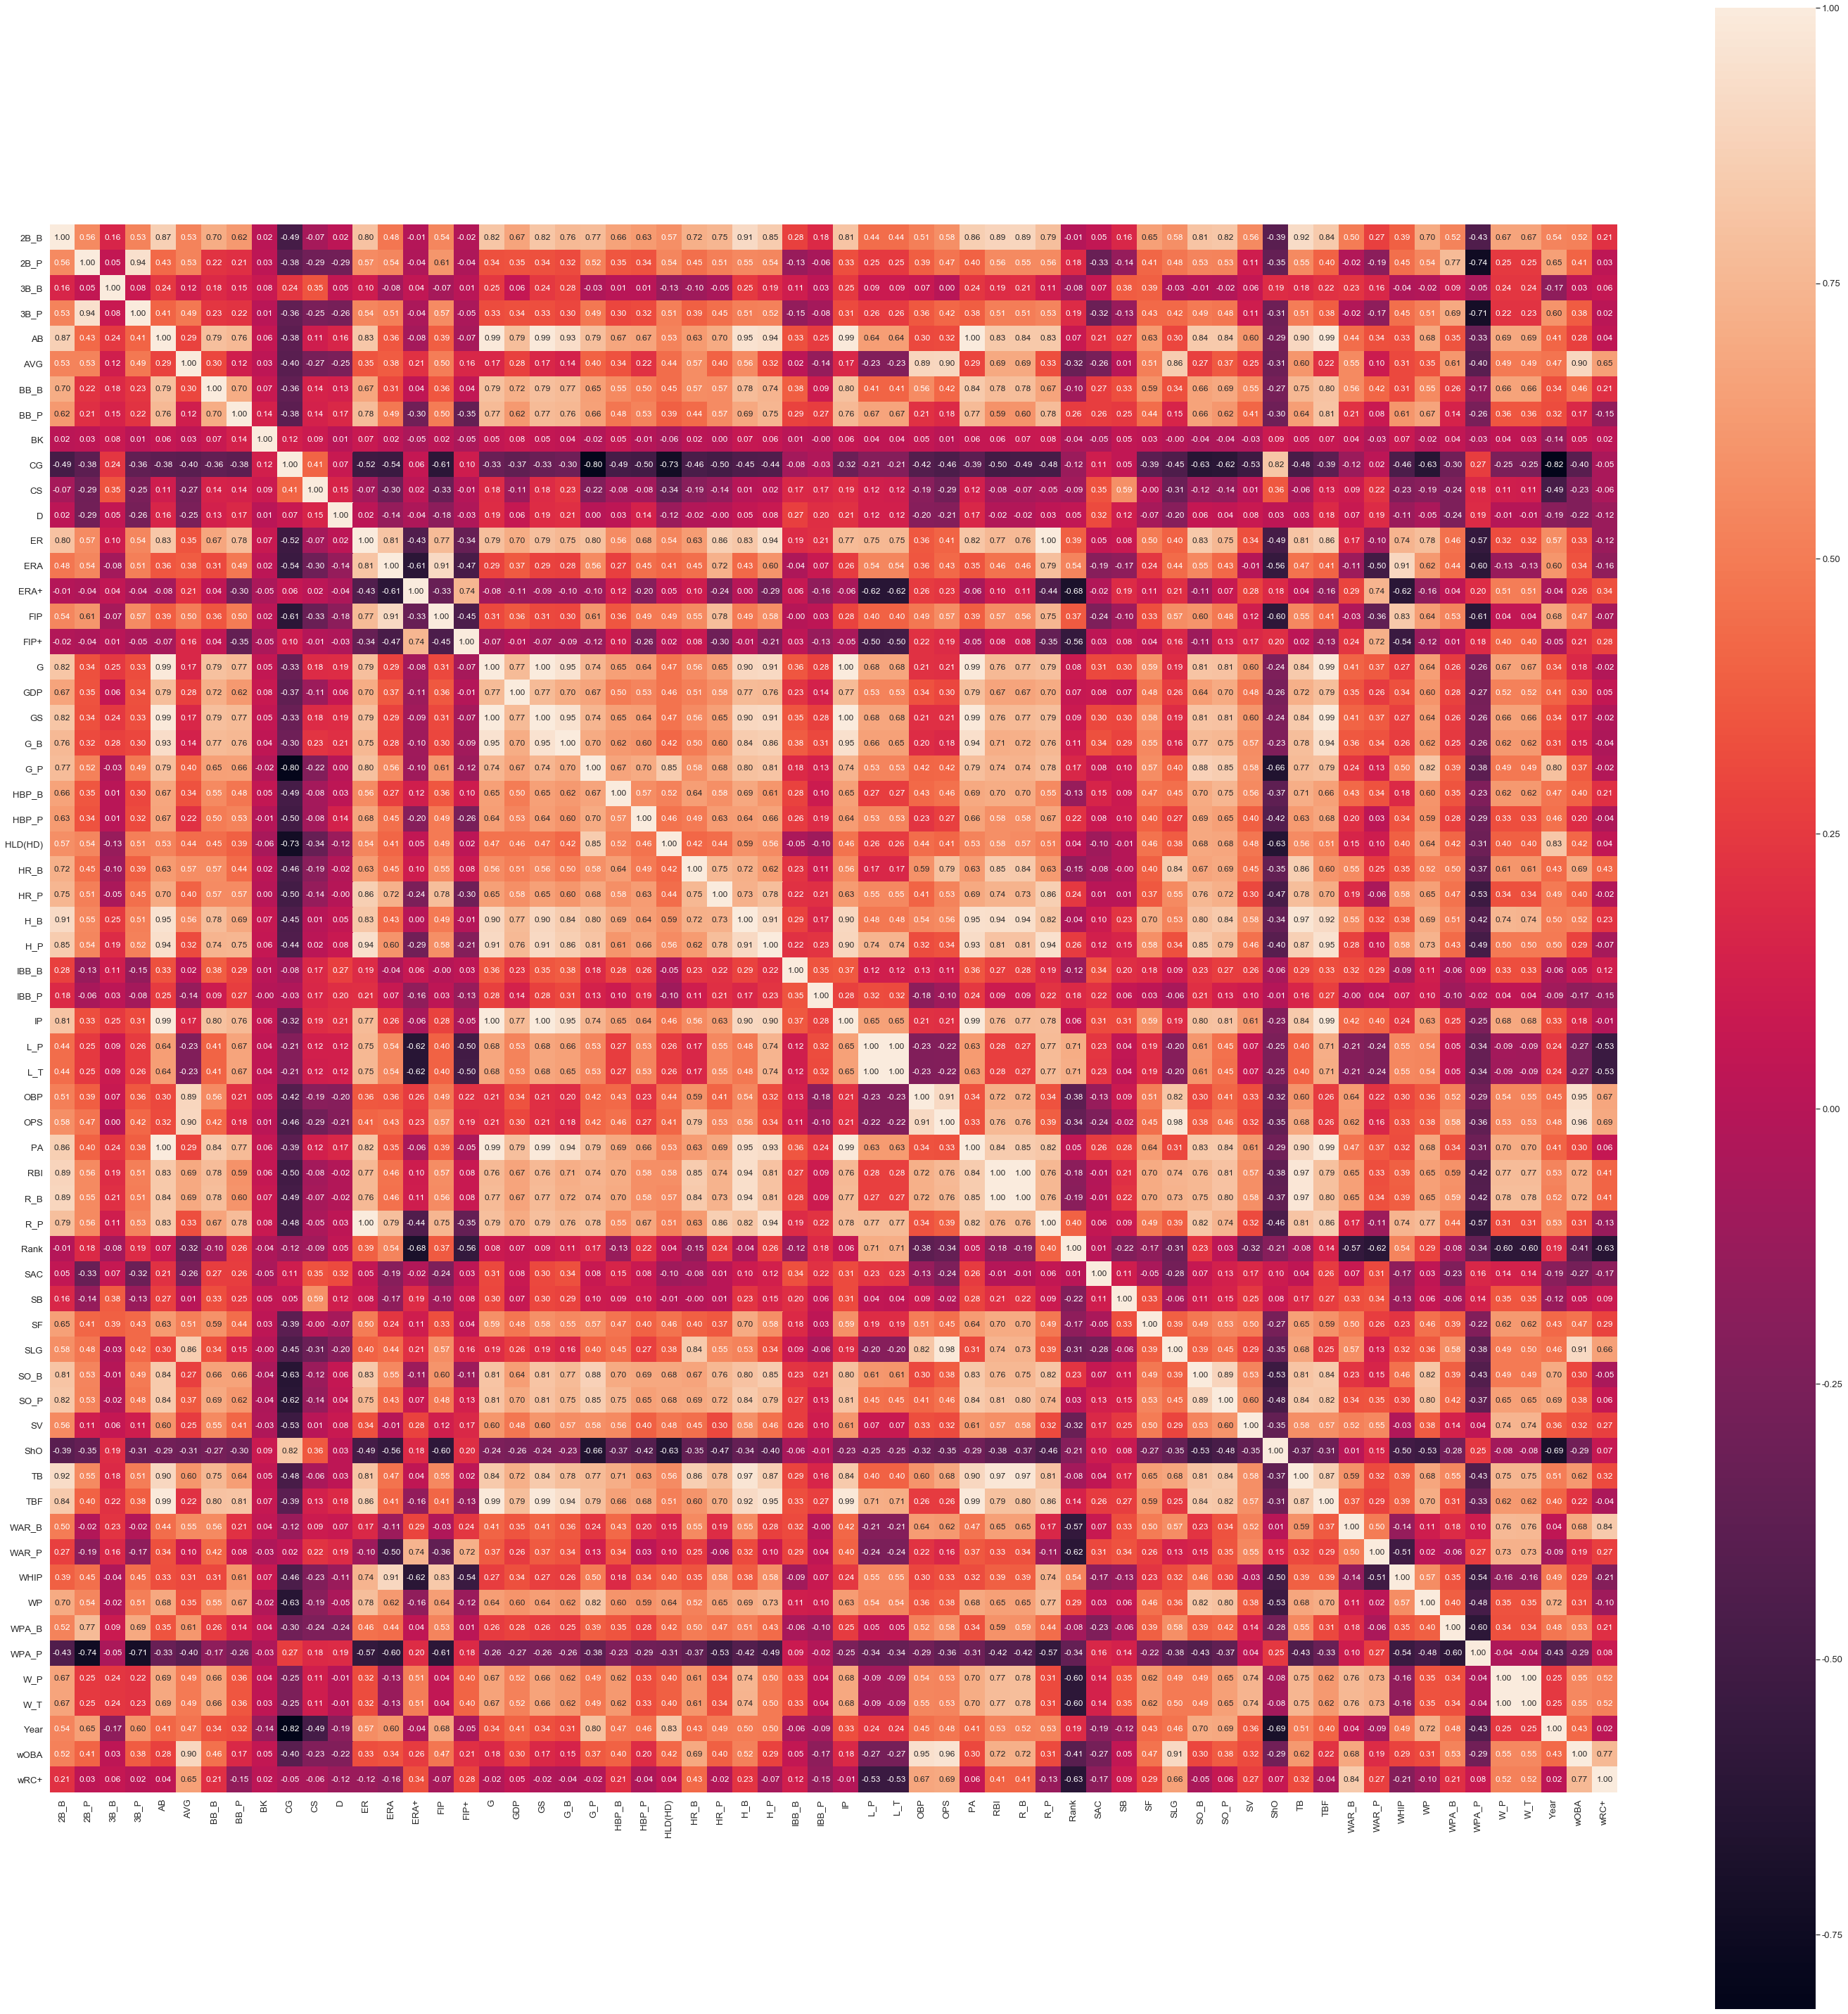

In [258]:
import seaborn as sns

# 특성 간의 상관계수 행렬을 계산합니다.
corr = X[X.columns].corr(method='pearson')

# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='NanumGothic')
plt.figure(figsize=(40, 40))

sns.set(font_scale=1.2)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 12},
            yticklabels=X.columns,
            xticklabels=X.columns)

plt.tight_layout()
plt.show()

Feature 수가 많아 숫자가 정확히 보이지는 않지만, 색깔 만으로도 높은 상관관계를 가진 Feature가 많다는 사실을 확인할 수 있다.

### 다중공선성 확인
[<h3>최대 VIF 계수가 10이 넘지 않을 때 까지 반복해주세요. 클릭 시 아래로 내려갑니다.</h3>](#다중공선성-확인-반복)

In [259]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 생략 row수 제한 해제
pd.set_option('display.max_rows', 62)

# 각 특성의 VIF 계수 출력
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif.round(1)

,VIF Factor,features
0,inf,2B_B
1,33.8,2B_P
2,inf,3B_B
3,15.8,3B_P
4,13900154.2,AB
5,79787.9,AVG
6,153881.6,BB_B
7,3900.3,BB_P
8,4.9,BK
9,25.0,CG


### 다중공선성이 높은 Feature를 제거

여러 차례 다중공선성 검사를 반복하고, 높은 Feature를 제거합니다.

각 차례를 모두 기록합니다.

<b>1. VIF 계수가 발산하는 Feature 제거:
    
    '2B_B' (2루타_타자)
    '3B_B' (3루타_타자)
    'D' (무승부)
    'G' (경기 수)
    'HR_B' (홈런_타자)
    'H_B' (안타_타자)
    'L_T' (패배_팀)
    'TB' (총 루타 수)
    'W_T' (승리_팀)
</b>

In [260]:
X = X.drop(['2B_B', '3B_B', 'D', 'G', 'HR_B', 'H_B', 'L_T', 'TB', 'W_T'], axis=1)

<b> 2. VIF 계수가 가장 높은 Feature 제거: 'PA' (타석)</b>

In [261]:
X = X.drop(['PA'], axis=1)

<b>3. 'OPS' (출루율 + 장타율) 제거</b>

In [262]:
X = X.drop(['OPS'], axis=1)

<b>4. 'OBP' (출루율) 제거</b>

In [263]:
X = X.drop(['OBP'], axis=1)

<b>5. 'IP' (이닝) 제거</b>

In [264]:
X = X.drop(['IP'], axis=1)

<b>6. 'TBF' (상대한 타자 수) 제거</b>

In [265]:
X = X.drop(['TBF'], axis=1)

<b>7. 'GS' (선발 경기 수) 제거</b>

In [266]:
X = X.drop(['GS'], axis=1)

<b>8. 'wOBA' (가중 출루율) 제거</b>

In [267]:
X = X.drop(['wOBA'], axis=1)

<b>9. 'WHIP' (이닝 당 출루 허용율) 제거</b>

In [268]:
X = X.drop(['WHIP'], axis=1)

<b>10. 'Year' (시즌) 제거</b>

In [269]:
X = X.drop(['Year'], axis=1)

<b>11. 'R_B' (득점_타자) 제거</b>

In [270]:
X = X.drop(['R_B'], axis=1)

<b>12. 'AB' (타수) 제거</b>

In [271]:
X = X.drop(['AB'], axis=1)

<b>13. 'ERA' (평균 자책점) 제거</b>

In [272]:
X = X.drop(['ERA'], axis=1)

<b>14. 'R_P' (실점_투수) 제거</b>

In [273]:
X = X.drop(['R_P'], axis=1)

<b>15. 'AVG' (타율) 제거</b>

In [274]:
X = X.drop(['AVG'], axis=1)

<b>16. 'SLG' (장타율) 제거</b>

In [275]:
X = X.drop(['SLG'], axis=1)

<b>17. 'ER' (자책점) 제거</b>

In [276]:
X = X.drop(['ER'], axis=1)

<b>18. 'wRC+' (wOBA 기반 득점 생산) 제거</b>

In [277]:
X = X.drop(['wRC+'], axis=1)

<b>19. 'H_P' (피안타_투수) 제거</b>

In [278]:
X = X.drop(['H_P'], axis=1)

<b>20. 'W_P' (승리_투수) 제거</b>

In [279]:
X = X.drop(['W_P'], axis=1)

<b>21. 'FIP+' (투수 개인 FIP / 리그 평균 FIP) 제거 | FIP: 수비 무관 평균 자책점</b>

In [280]:
X = X.drop(['FIP+'], axis=1)

<b>22. 'RBI' (타점) 제거</b>

In [281]:
X = X.drop(['RBI'], axis=1)

<b>23. 'G_B' (타자 경기 수) 제거</b>

In [282]:
X = X.drop(['G_B'], axis=1)

<b>24. 'G_P' (투수 경기 수) 제거</b>

In [283]:
X = X.drop(['G_P'], axis=1)

<b>25. 'FIP' (수비 무관 평균 자책점) 제거</b>

In [284]:
X = X.drop(['FIP'], axis=1)

<b>26. 'L_P' (패배_투수) 제거</b>

In [285]:
X = X.drop(['L_P'], axis=1)

<b>27. 'SO_P' (삼진_투수) 제거</b>

In [286]:
X = X.drop(['SO_P'], axis=1)

<b>28. 'BB_B' (볼넷_타자) 제거</b>

In [287]:
X = X.drop(['BB_B'], axis=1)

<b>29. 'SO_B' (삼진_타자) 제거</b>

In [288]:
X = X.drop(['SO_B'], axis=1)

<b>30. 'BB_P' (볼넷_투수) 제거</b>

In [289]:
X = X.drop(['BB_P'], axis=1)

<b>31. 'ERA+' (조정 방어율) 제거</b>

In [290]:
X = X.drop(['ERA+'], axis=1)

<b>32. 'GDP' (병살타) 제거</b>

In [291]:
X = X.drop(['GDP'], axis=1)

<b>33. 'WAR_P' (대체 수준 대비 승리 기여도_투수) 제거<b>

In [292]:
X = X.drop(['WAR_P'], axis=1)

<b>34. 'CS' (도루 실패) 제거</b>

In [293]:
X = X.drop(['CS'], axis=1)

<b>35. 'WAR_B' (대체 수준 대비 승리 기여도_타자) 제거</b>

In [294]:
X = X.drop(['WAR_B'], axis=1)

<b>36. 'HBP_B' (몸에 맞는 공_타자) 제거</b>

In [295]:
X = X.drop(['HBP_B'], axis=1)

<b>37. 'SF' (희생 플라이) 제거</b>

In [296]:
X = X.drop(['SF'], axis=1)

<b>38. 'HR_P' (홈런_투수) 제거</b>

In [297]:
X = X.drop(['HR_P'], axis=1)

<b>39. 'HBP_P' (몸에 맞는 공_투수) 제거</b>

In [298]:
X = X.drop(['HBP_P'], axis=1)

<b>40. '2B_P' (2루타_투수) 제거</b>

In [299]:
X = X.drop(['2B_P'], axis=1)

<b>41. 'SV' (세이브) 제거</b>

In [300]:
X = X.drop(['SV'], axis=1)

<b>42. 'WP' (폭투) 제거</b>

In [301]:
X = X.drop(['WP'], axis=1)

<b>43. 'SAC' (희생타) 제거</b>

In [302]:
X = X.drop(['SAC'], axis=1)

In [303]:
X.columns

Index(['3B_P', 'BK', 'CG', 'HLD(HD)', 'IBB_B', 'IBB_P', 'Rank', 'SB', 'ShO',
       'WPA_B', 'WPA_P'],
      dtype='object')

### 다중공선성 확인 반복
[<h3>최대 VIF 계수가 10이 넘지 않을 때 까지 반복해주세요. 클릭 시 위로 올라갑니다.</h3>](#다중공선성-확인)

### 남은 특성

In [304]:
X.columns

Index(['3B_P', 'BK', 'CG', 'HLD(HD)', 'IBB_B', 'IBB_P', 'Rank', 'SB', 'ShO',
       'WPA_B', 'WPA_P'],
      dtype='object')

차례대로

<b>3루타_투수, 보크, 완투, 홀드, 고의사구_타자, 고의사구_투수, 해당 시즌 순위, 희생 번트, 완봉, 승리 확률 기여도_타자, 승리 확률 기여도_투수</b>

위 총 11개 특성으로 학습

### 남은 특성의 상관관계

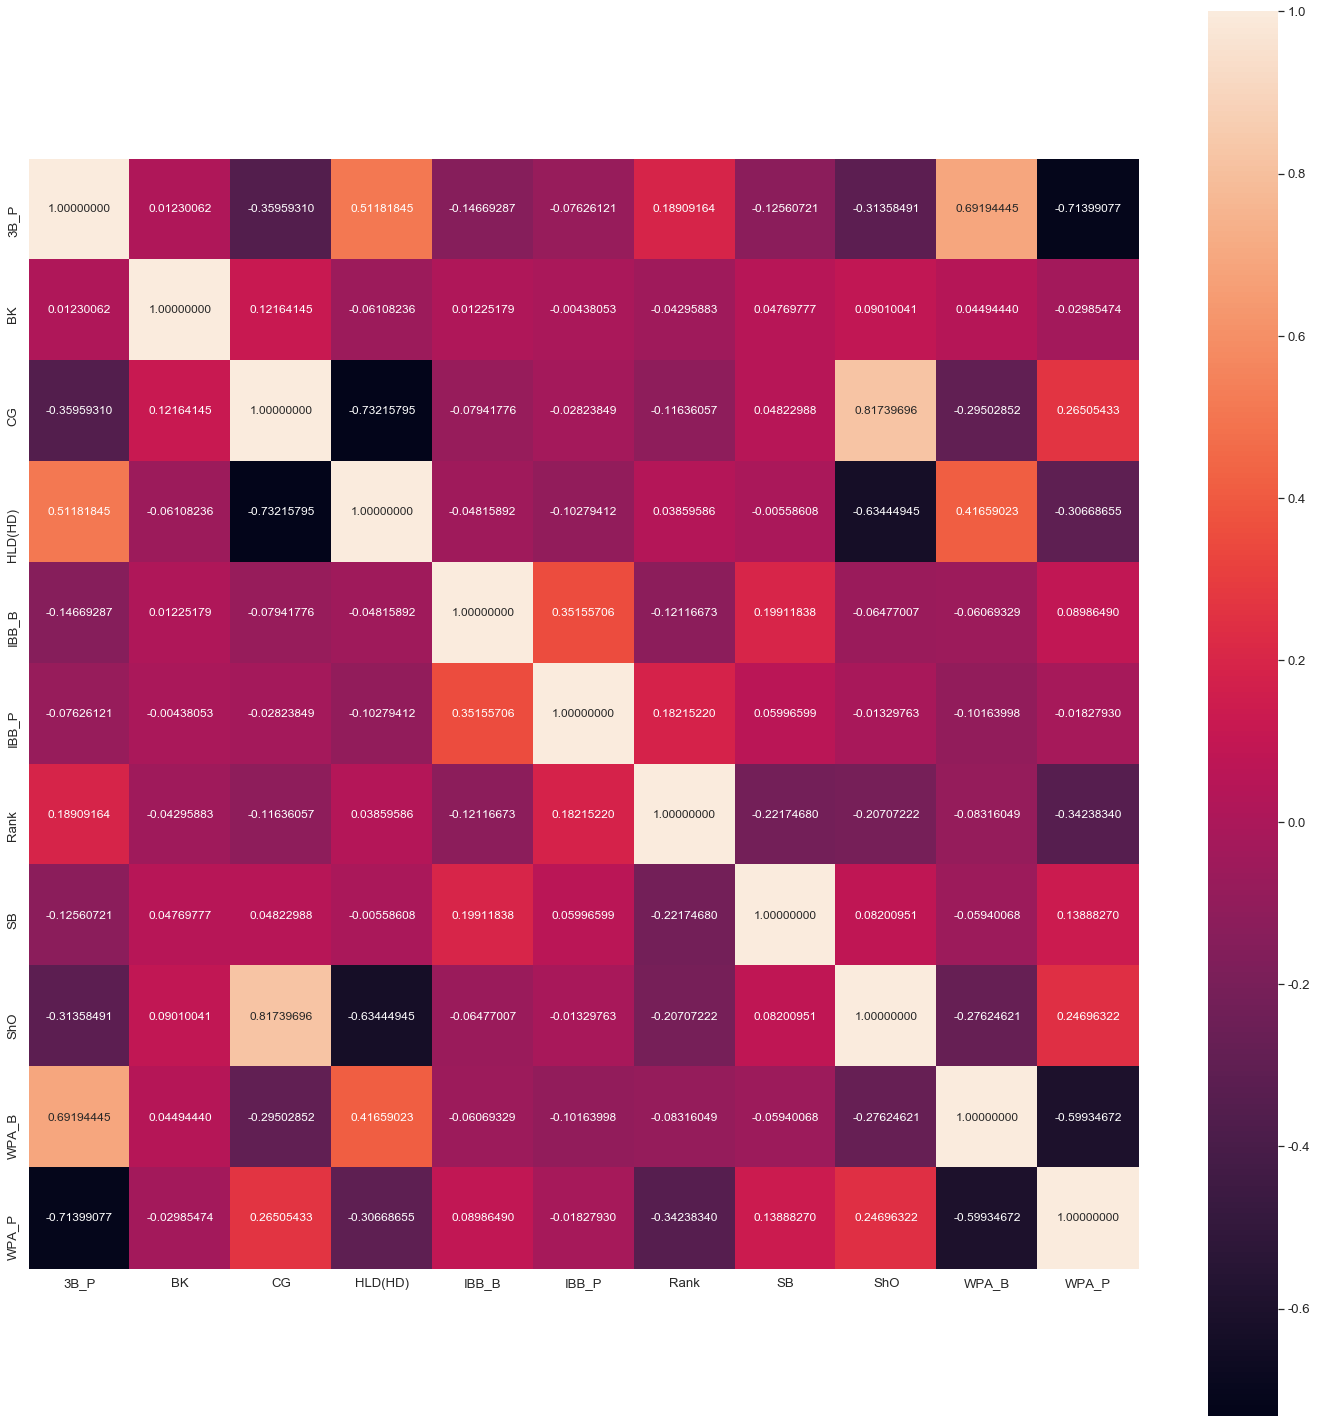

In [305]:
# 특성 간의 상관계수 행렬을 계산합니다.
corr = X[X.columns].corr(method='pearson')

# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='NanumGothic')
plt.figure(figsize=(20, 20))

sns.set(font_scale=1.2)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.8f',
            annot_kws={'size': 12},
            yticklabels=X.columns,
            xticklabels=X.columns)

plt.tight_layout()
plt.show()

### 학습 데이터와 테스트 데이터 분리

In [306]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

In [307]:
# 정규분포 정규화(= StandardScaler)
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_std = (X_train - X_mean) / X_std
X_test_std = (X_test - X_mean) / X_std

### 모델 구성

'3B_P(3루타_투수)'는 이미 'WPA_P(승리 확률 기여도_투수)에서 계산이 되었을 것으로 판단했고,

'BK(보크)'는 승률과는 크게 상관이 없을 것으로 판단했기 때문에

중요하지 않은 Feature에 규제를 가하기 위해서 <b>규제가 있는 모델인 Ridge, Lasso</b>를 사용하기로 결정

In [308]:
from sklearn.linear_model import Ridge, Lasso

# Ridge
ridge = Ridge(alpha=1e-1, random_state=64)

# Lasso
lasso = Lasso(alpha=1e-3, random_state=64)

ridge_model = ridge.fit(X_train_std, y_train)
lasso_model = lasso.fit(X_train_std, y_train)

In [309]:
print('Ridge:', ridge_model.score(X_train_std, y_train), ridge_model.score(X_test_std, y_test))
print('Lasso:', lasso_model.score(X_train_std, y_train), lasso_model.score(X_test_std, y_test))

Ridge: 0.8090131955841412 0.7849829056567879
Lasso: 0.8062078937140456 0.7846571145664472


### 예측값과 실제값 비교 그래프

성능이 조금 더 좋은 Ridge 모델로 테스트

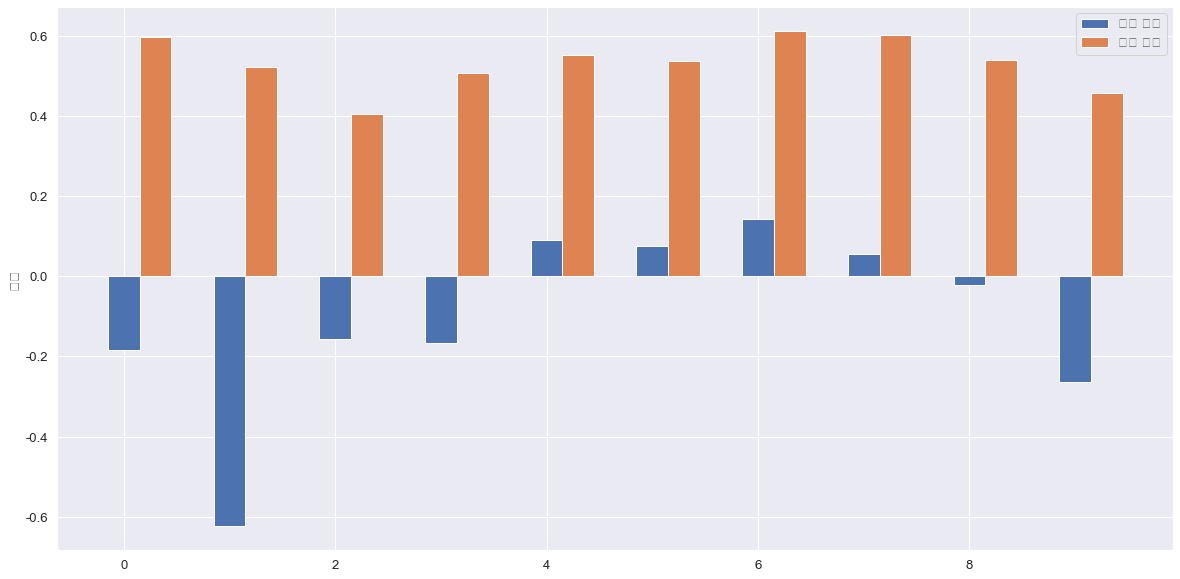

In [310]:
w_ = 0.3
plt.figure(figsize=(20, 10))

predict = ridge_model.predict(X_test[:10])
plt.bar(range(len(predict)), predict, width=w_)

value = y_test.values[:10]
plt.bar([i + w_ for i in range(len(value))], value, width=w_)

plt.ylabel('승률')
plt.legend(('예측 승률', '실제 승률'))

plt.show()

---

## 딥러닝

샘플 개수가 적을 수록 과대적합이 쉽게 일어나기 때문에 작은 모델을 사용하는 것이 과대적합을 피하는 방법이 될 수 있다.

본 프로젝트에서는 64개의 유닛을 가진 2개의 은닉 층으로 작은 네트워크를 구성해서 사용한다.

---